In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from IPython.display import Image

# in order to always get the same result
tf.random.set_seed(1)
np.random.seed(1)

# Get CIFAR-10 Data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


# CIFAR-10 Preprocess

In [0]:
# normalize data
x_train = x_train/255
x_test = x_test/255

# Modeling

In [5]:
#I completely remove all the Dense layer, as it seems fully connected layer is not performing well on the CIFAR-10 dataset, and change it with convolutional layer.
#Other than that, I also added batch normalization, and upsampling.

model = Sequential()

model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())     # 32x32x32
model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))      # 16x16x32
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 16x16x32
model.add(BatchNormalization())     # 16x16x32
model.add(UpSampling2D())
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 32x32x32
model.add(BatchNormalization())
model.add(Conv2D(3,  kernel_size=1, strides=1, padding='same', activation='sigmoid'))   # 32x32x3

model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9

In [6]:
#I also made it a denoising autoencoder, in which I added random noise to the original image, and the autoencoder is trying to denoise that.
# We want to add different noise vectors for each epoch
num_epochs = 3
NOISE = 0.3     # Set to 0 for a regular (non-denoising...) autoencoder
for i in range(num_epochs):
    noise = np.random.normal(0, NOISE, x_train.shape)
    model.fit(x_train + noise, x_train, epochs=1, batch_size=100)

500/500 [==============================] - 216s 433ms/step - loss: 0.0063 - accuracy: 0.6832


In [0]:
x_test = x_test[:400]
noise = np.random.normal(0, NOISE, x_test.shape)
pred_imgs = model.predict(x_test + noise)

In [0]:
# The next three methods to visualize input/output of our model side-by-side
def hstackimgs(min, max, images):
    return np.hstack(images[i] for i in range(min, max))

def sqstackimgs(length, height, images):
    return np.vstack(hstackimgs(i*length, (i+1)*length, images) for i in range(height))

def sbscompare(images1, images2, length, height):
    A = sqstackimgs(length, height, images1)
    B = sqstackimgs(length, height, images2)
    C = np.ones((A.shape[0], 32, 3))
    return np.hstack((A, C, B))

# Calculate Reconstruction Error & Visualize Reconstructed Images

In [0]:
errors = []
for i in range(len(x_test)):
  mse = np.mean((x_test[i]-pred_imgs[i])**2)
  errors.append(mse)

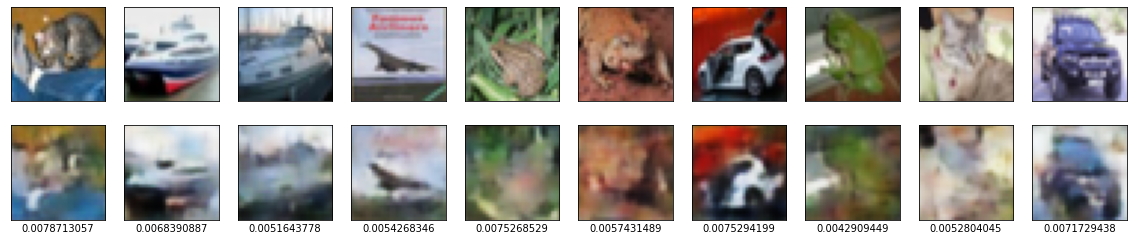

In [10]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(pred_imgs[i].reshape(32, 32, 3))
    plt.gray()
    #ax.get_xaxis().set_visible(False)
    plt.xticks([])
    ax.get_yaxis().set_visible(False)

    #display error
    plt.xlabel(str(np.round(errors[i],10)))
plt.show()